100%|██████████| 30000/30000 [00:08<00:00, 3738.39it/s]


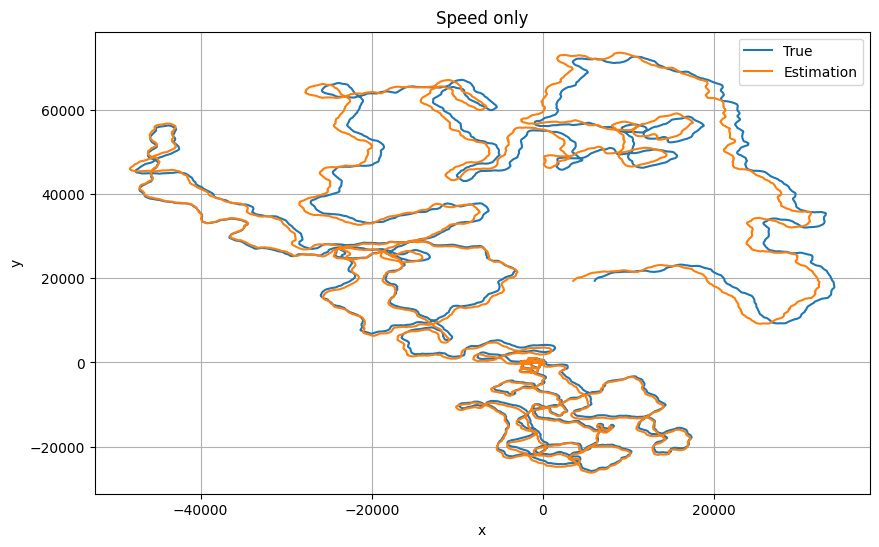

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# 系统变量
n = np.array([0, 0, 0, 0])  # 状态向量 x, y, theta, v
u = np.array([0.1, 0.1])    # 控制输入 dtheta, dv

# 状态转移函数
def f(n, u):
    x, y, theta, v = n
    dtheta, dv = u
    return np.array([
        x + v * np.cos(theta),
        y + v * np.sin(theta),
        theta + dtheta,
        v + dv
    ])

# 观测函数：只能观测到角度 theta 和速度 v
def h(n):
    return np.array([n[2], n[3]])  # 返回 theta 和 v

# 线性化函数：计算雅可比矩阵 F
def linearize(f, n, u):
    F = np.zeros((4, 4))
    for i in range(4):
        for j in range(4):
            n_ = n.copy()
            n_[j] += 1e-6
            F[i, j] = (f(n_, u)[i] - f(n, u)[i]) / 1e-6
    return F

# EKF 变量初始化
P = np.eye(4)              # 状态协方差矩阵
Q = 0.01 * np.eye(4)       # 过程噪声协方差矩阵
R = 0.1 * np.eye(2)        # 观测噪声协方差矩阵（观测两个变量）
n_est = np.array([0, 0, 0, 0])  # 状态估计初始值
n_true = np.array([0, 0, 0, 0]) # 系统真实状态初始值

n_trues = []
n_preds = []
n_noised = []
n_noised.append(n_true)
# 模拟过程
import tqdm
for i in tqdm.tqdm(range(30000)):
    # 模拟真实系统
    u = np.random.multivariate_normal(np.array([0, 0]), 0.01 * np.eye(2))  # 随机控制输入
    process_noise = np.random.multivariate_normal(np.zeros(4), Q)
    n_true = f(n_true, u) + process_noise

    # EKF 预测步骤
    F_k = linearize(f, n_est, u)  # 计算雅可比矩阵 F_k
    n_pred = f(n_est, u)          # 状态预测
    P = F_k @ P @ F_k.T + Q       # 误差协方差预测

    # 生成测量值并添加噪声
    measurement_noise = np.random.multivariate_normal(np.zeros(2), R)
    z = h(n_true) + measurement_noise  # 观测值

    naive_est = n_noised[-1].copy()
    naive_est[0] += naive_est[3] * np.cos(naive_est[2])
    naive_est[1] += naive_est[3] * np.sin(naive_est[2])
    naive_est[2] = z[0]
    naive_est[3] = z[1]
    n_noised.append(naive_est)
    # EKF 更新步骤
    # 观测矩阵 H_k，对于 h(n) = [theta, v]，H_k 为：
    H_k = np.array([
        [0, 0, 1, 0],  # 对 theta 的观测
        [0, 0, 0, 1]   # 对 v 的观测
    ])
    y_k = z - h(n_pred)  # 残差
    S_k = H_k @ P @ H_k.T + R  # 残差协方差
    K_k = P @ H_k.T @ np.linalg.inv(S_k)  # 卡尔曼增益

    # 更新状态估计和误差协方差
    n_est = n_pred + K_k @ y_k  # 状态更新
    P = (np.eye(4) - K_k @ H_k) @ P  # 协方差更新

    # 记录结果
    n_trues.append(n_true)
    n_preds.append(n_est)

# 转换为数组
n_trues = np.array(n_trues)
n_preds = np.array(n_preds)
n_noised = np.array(n_noised)
# 绘制轨迹
plt.figure(figsize=(10, 6))
plt.plot(n_trues[:, 0], n_trues[:, 1], label='True')
plt.plot(n_preds[:, 0], n_preds[:, 1], label='Estimation')
#plt.plot(n_noised[:, 0], n_noised[:, 1], label='Noised')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Speed only')
plt.grid()
plt.show()


100%|██████████| 500/500 [00:00<00:00, 1244.49it/s]


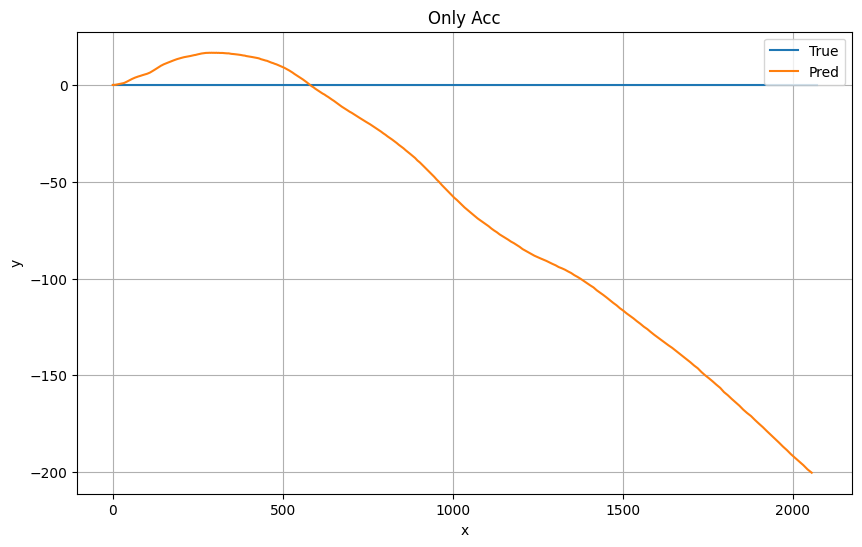

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# 系统变量
n = np.array([0, 0, 0, 0, 0, 0])  # 状态向量 x, y, theta, v, dtheta, dv
u = np.array([0.001, 0.001])  # 控制输入 ddtheta, ddv

# 状态转移函数
def f(n, u):
    x, y, theta, v, dtheta, dv = n
    ddtheta, ddv = u
    return np.array([
        x + v * np.cos(theta),
        y + v * np.sin(theta),
        theta + dtheta,
        v + dv,
        dtheta + ddtheta,
        dv + ddv
    ])

# 观测函数：只能观测到加速度 dtheta 和 dv
def h(n):
    return np.array([n[4], n[5]])

# 线性化函数：计算雅可比矩阵 F
def linearize(f, n, u):
    F = np.zeros((6, 6))
    for i in range(6):
        for j in range(6):
            n_ = n.copy()
            n_[j] += 1e-6
            F[i, j] = (f(n_, u)[i] - f(n, u)[i]) / 1e-6
    return F

# EKF 变量初始化
P = np.eye(6)  # 状态协方差矩阵
Q = 0.00001 * np.eye(6)  # 过程噪声协方差矩阵
R = np.array([
    [7.615e-7, 0],
    [0, 1.54e-3]
])
R = np.array([
    [7.615e-5, 0],
    [0, 9.62e-5]
])
n_est = np.array([0, 0, 0, 0, 0, 0])  # 状态估计初始值
n_true = np.array([0, 0, 0, 0, 0, 0])  # 系统真实状态初始值

n_trues = []
n_preds = []

# 模拟过程
import tqdm
for i in tqdm.tqdm(range(500)):
    #u = np.random.multivariate_normal(np.array([0, 0]), 0.00001 * np.eye(2))  # 随机控制输入
    u = np.array([0,0.0001])
    # 模拟真实系统
    process_noise = np.random.multivariate_normal(np.zeros(6), Q)
    n_true = f(n_true, u) #+ process_noise

    # EKF 预测步骤
    F_k = linearize(f, n_est, u)  # 计算雅可比矩阵 F_k
    n_pred = f(n_est, u)  # 状态预测
    P = F_k @ P @ F_k.T + Q  # 误差协方差预测

    # 生成测量值并添加噪声
    measurement_noise = np.random.multivariate_normal(np.zeros(2), R)
    z = h(n_true) + measurement_noise  # 观测值

    # EKF 更新步骤
    H_k = np.array([
        [0, 0, 0, 0, 1, 0],  # 对 dtheta 的观测
        [0, 0, 0, 0, 0, 1]   # 对 dv 的观测
    ])
    y_k = z - h(n_pred)  # 残差
    S_k = H_k @ P @ H_k.T + R  # 残差协方差
    K_k = P @ H_k.T @ np.linalg.inv(S_k)  # 卡尔曼增益

    # 更新状态估计和误差协方差
    n_est = n_pred + K_k @ y_k  # 状态更新
    P = (np.eye(6) - K_k @ H_k) @ P  # 协方差更新

    # 记录结果
    n_trues.append(n_true)
    n_preds.append(n_est)

# 转换为数组
n_trues = np.array(n_trues)
n_preds = np.array(n_preds)

# 绘制轨迹
plt.figure(figsize=(10, 6))
plt.plot(n_trues[:, 0], n_trues[:, 1], label='True')
plt.plot(n_preds[:, 0], n_preds[:, 1], label='Pred')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Only Acc')
plt.grid()
plt.show()
